In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import io
from nltk.tokenize import word_tokenize
import re

from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm

import matplotlib.pyplot as plt

gpu_device = torch.device("cuda:0")
cpu_device = torch.device("cpu")
gpu_device, cpu_device

(device(type='cuda', index=0), device(type='cpu'))

In [4]:
# todos 1) Make generalize tokenizer 2) make preprocessing different so we can use while custom dataset
class DateDataset(Dataset):
    def __init__(self, DATASET_PATH = "dataset/Assignment2aDataset.txt", split="train"):
        df = pd.read_csv(DATASET_PATH, names = ["source", "target"])
        df["source"] = df["source"].apply(lambda x: x.strip()[1:-1].replace("/", "-"))
        df["target"] = df["target"].apply(lambda x: x.strip()[1:-1])
        df_train, df_test = train_test_split(df, random_state=42, test_size=0.1)
        
        # tokenize
        en_tokenizer = get_tokenizer('spacy', language='en')   
        counter = Counter() # dict of {token: Freq}     
        for source in df["source"]:
            counter.update(en_tokenizer(source))

        for source in df["target"]:
            counter.update(en_tokenizer(source))
        
        voc = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])    
        
        # create data
        if split == "train":
            self.data_df = df_train
        else:
            self.data_df = df_test
            
        data = []
        for (source, target) in zip(self.data_df["source"], self.data_df["target"]):
            s_tensor_ = torch.tensor([voc[token] for token in en_tokenizer(source)])
            t_tensor_ = torch.tensor([voc[token] for token in en_tokenizer(target)])
            data.append((s_tensor_, t_tensor_))
        
        self.voc = voc
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
BOS_IDX = train_dataset.voc["<bos>"]
EOS_IDX = train_dataset.voc["<eos>"]
PAD_IDX = train_dataset.voc["<pad>"]
train_dataset = DateDataset(split="train")

def generate_batch(data_batch):
    s_batch, t_batch = [], []
    for (s_item, t_item) in data_batch:
        s_batch.append(torch.cat([torch.tensor([BOS_IDX]), s_item, torch.tensor([EOS_IDX])], dim=0))
        t_batch.append(torch.cat([torch.tensor([BOS_IDX]), t_item, torch.tensor([EOS_IDX])], dim=0))
        
    s_batch = pad_sequence(s_batch, padding_value=PAD_IDX)
    return s_batch.T.to(gpu_device), torch.stack(t_batch).to(gpu_device)
train_dataloader = DataLoader(train_dataset, batch_size=18000, collate_fn=generate_batch)


/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [8]:
test_dataset = DateDataset(split="test")
test_dataloader = DataLoader(test_dataset, batch_size=4000, collate_fn=generate_batch)

/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # input.shape = (N, Batch, Hidden)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
    
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
        
    def forward(self, enc_all_ops, dec_h_so_far):
        # enc_all_ops = (B, N, H)
        # dec_h_so_far = (B, H)
        scores = self.Va(torch.tanh(self.Ua(enc_all_ops) + self.Wa(dec_h_so_far))) # (B, N)
        weights = F.softmax(scores, dim=-1) # (B, N)
        context = torch.bmm(weights, enc_all_ops) # (B, N, H)
        return context, weights

In [28]:
s, t = next(iter(test_dataloader))
s.shape, t.shape

(torch.Size([4000, 7]), torch.Size([4000, 7]))

In [24]:
vocab_size = len(train_dataset.voc)
enc_hidden_size = 256
encoder = EncoderRNN(vocab_size, enc_hidden_size).to(gpu_device)

In [31]:
enc_all_ops, enc_h = encoder(s)
enc_all_ops.shape, enc_h.shape

(torch.Size([4000, 7, 256]), torch.Size([1, 4000, 256]))

In [32]:
BahdanauAttention(hidden_size=enc_hidden_size).to(gpu_device)(enc_all_ops, enc_h)

torch.Size([4000, 7, 256])


In [123]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.MAX_LENGTH = 7
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.linear = nn.Linear(hidden_size, output_size)
        self.attention = BahdanauAttention(hidden_size=hidden_size).to(gpu_device)
        
    def forward(self, inputs):
        target , encoder_op, enc_all_ops = inputs # [B, 7], [1, B, H], [B, N, H]
        
        i = 0
        decoder_logits= []
        decoder_ip_h = encoder_op
        decoder_ip_x = target[:,0]
        for i in range(self.MAX_LENGTH):
            
            # forward step
            decoder_ip_x = F.relu(self.embedding(decoder_ip_x)) # [B, H]
            context, weights = self.attention(enc_all_ops, decoder_ip_x)
            
            decoder_ip_x = torch.unsqueeze(decoder_ip_x, dim=1) # [B, 1, H]
            all_ops, op = self.gru(decoder_ip_x, decoder_ip_h) # [B, 1, H], [1, B, H]
            op = torch.squeeze(op) # [B,H]
            logits = self.linear(op) # [B, output_size]
            decoder_logits.append(logits)
            
            
            decoder_ip_h = torch.permute(all_ops, (1,0,2)) # [1, B, H]  
            _, decoder_ip_x = torch.max(logits, dim=-1) # [B,1]
        
        decoder_logits = torch.stack(decoder_logits, dim=1) # [B, 7, output_size]
        log_probs = F.log_softmax(decoder_logits, dim=-1) 
        return log_probs, decoder_logits, None

In [124]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [126]:
vocab_size = len(train_dataset.voc)
enc_hidden_size = 256
encoder = EncoderRNN(vocab_size, enc_hidden_size).to(gpu_device)
decoder = DecoderRNN(enc_hidden_size, vocab_size).to(gpu_device)

In [127]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.005)
criterion = nn.NLLLoss()

In [128]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder((target_tensor, encoder_hidden, encoder_outputs))

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.reshape(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [129]:
def val_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):
    with torch.no_grad():
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder((target_tensor, encoder_hidden, encoder_outputs))
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.reshape(-1)
            )

            total_loss += loss.item()
            pred_indices = torch.argmax(decoder_outputs, dim=-1)
            accuracy = torch.all(target_tensor == pred_indices, dim=1).sum()/len(target_tensor)

        return total_loss / len(dataloader), accuracy

In [130]:
train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

5.7844109535217285

In [138]:
start = time.time()
plot_losses, val_losses = [], []
print_loss_total = 0  # Reset every print_every
val_loss_total = 0
n_epochs = 150
print_every=1
tq_obj = tqdm(range(1,n_epochs+1))
for epoch in tq_obj:
    loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    
    val_loss, val_acc = val_epoch(test_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    val_loss_total += val_loss


    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        plot_losses.append(print_loss_avg)
        
        val_loss_avg = val_loss_total/print_every
        val_losses.append(val_loss_avg)
        val_loss_total = 0
        
        tq_obj.set_description_str(f"train loss: {round(print_loss_avg, 3)} val loss: {round(val_loss_avg, 3)} val acc: {val_acc} Time: {(timeSince(start, epoch / n_epochs))}")

train loss: 0.039 val loss: 0.071 val acc: 0.9565000534057617 Time: 5m 16s (- 0m 0s): 100%|█| 150/150


In [139]:
round(print_loss_avg, 3)

0.039

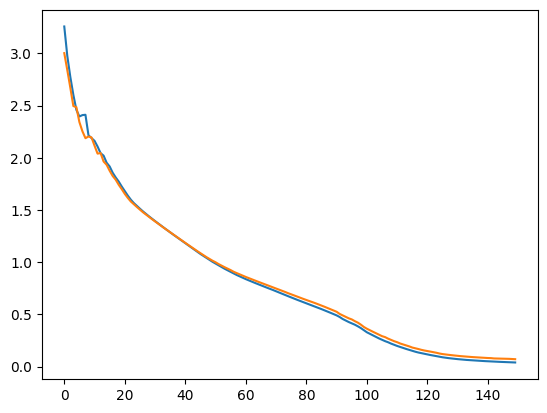

In [140]:
plt.plot(plot_losses, label="train")
plt.plot(val_losses, label="val")

In [141]:
test_x, test_y = next(iter(test_dataloader))
test_x, test_y = test_x, test_y
test_x.shape, test_y.shape

(torch.Size([4000, 7]), torch.Size([4000, 7]))

In [142]:
test_x[0], test_y[0]

(tensor([  2,   7,  26, 682,   3,   1,   1], device='cuda:0'),
 tensor([  2, 682,  10,  21,  10,  21,   3], device='cuda:0'))

In [143]:
encoder_outputs, encoder_hidden = encoder(test_x)
decoder_outputs, _, _ = decoder((test_y, encoder_hidden, encoder_outputs))

In [144]:
pred_indices = torch.argmax(decoder_outputs, dim=-1)
pred_indices

tensor([[  2, 682,  10,  ...,  10,  21,   3],
        [  2, 347,  10,  ...,  10,  45,   3],
        [  2, 438,  10,  ...,  10,  90,   3],
        ...,
        [  2, 328,  10,  ...,  10,  42,   3],
        [  2, 161,  10,  ...,  10,   9,   3],
        [  2, 240,  10,  ...,  10,  14,   3]], device='cuda:0')

In [145]:
torch.all(test_y == pred_indices, dim=1).sum()/len(test_y)

tensor(0.9583, device='cuda:0')

In [146]:
vocab_list = train_dataset.voc.get_itos()

In [147]:
for row in pred_indices:
    pred_str = ""
    for pred in row:
        pred_str += vocab_list[pred]
    print(pred_str)

<bos>1943-09-09<eos>
<bos>1532-05-23<eos>
<bos>1908-06-27<eos>
<bos>1766-07-24<eos>
<bos>2008-12-26<eos>
<bos>1844-10-10<eos>
<bos>1543-04-17<eos>
<bos>1745-05-28<eos>
<bos>2064-06-17<eos>
<bos>1589-03-24<eos>
<bos>1926-08-05<eos>
<bos>1632-03-10<eos>
<bos>1595-01-03<eos>
<bos>1536-01-19<eos>
<bos>2049-05-19<eos>
<bos>1837-12-30<eos>
<bos>1593-06-12<eos>
<bos>1986-04-11<eos>
<bos>1538-05-23<eos>
<bos>1781-12-28<eos>
<bos>1545-05-12<eos>
<bos>1561-04-11<eos>
<bos>2057-05-08<eos>
<bos>1653-10-29<eos>
<bos>1917-01-22<eos>
<bos>1799-04-29<eos>
<bos>1671-06-26<eos>
<bos>1904-11-15<eos>
<bos>1694-08-12<eos>
<bos>1962-12-06<eos>
<bos>1796-02-26<eos>
<bos>2006-09-20<eos>
<bos>2053-10-25<eos>
<bos>1568-08-22<eos>
<bos>1838-01-01<eos>
<bos>1649-11-10<eos>
<bos>1901-05-26<eos>
<bos>1543-11-20<eos>
<bos>1836-12-12<eos>
<bos>2037-03-17<eos>
<bos>1931-04-01<eos>
<bos>1886-08-09<eos>
<bos>2006-03-21<eos>
<bos>1525-11-14<eos>
<bos>1557-01-30<eos>
<bos>1830-03-15<eos>
<bos>1589-04-21<eos>
<bos>1709-08-

<bos>1756-04-01<eos>
<bos>2015-01-14<eos>
<bos>1722-01-20<eos>
<bos>1905-10-01<eos>
<bos>1569-10-04<eos>
<bos>1537-06-13<eos>
<bos>1799-08-06<eos>
<bos>1995-01-26<eos>
<bos>1526-12-26<eos>
<bos>1561-09-17<eos>
<bos>1867-03-23<eos>
<bos>1820-03-10<eos>
<bos>1910-04-13<eos>
<bos>2071-08-01<eos>
<bos>1729-07-14<eos>
<bos>1792-01-29<eos>
<bos>1971-11-23<eos>
<bos>1867-10-02<eos>
<bos>1657-10-16<eos>
<bos>1714-07-15<eos>
<bos>1593-08-10<eos>
<bos>2045-05-01<eos>
<bos>1564-02-14<eos>
<bos>1574-08-04<eos>
<bos>2003-09-19<eos>
<bos>2017-03-05<eos>
<bos>1854-06-02<eos>
<bos>1604-11-29<eos>
<bos>1953-02-08<eos>
<bos>2058-02-26<eos>
<bos>1779-04-18<eos>
<bos>1652-12-04<eos>
<bos>1674-03-19<eos>
<bos>1839-01-11<eos>
<bos>1842-05-25<eos>
<bos>1706-02-19<eos>
<bos>1673-07-26<eos>
<bos>1960-12-08<eos>
<bos>1914-01-11<eos>
<bos>1884-02-16<eos>
<bos>1854-09-17<eos>
<bos>1744-09-01<eos>
<bos>1580-05-09<eos>
<bos>1976-07-17<eos>
<bos>1749-08-04<eos>
<bos>1542-08-19<eos>
<bos>2062-08-22<eos>
<bos>1985-12-

In [38]:
a = torch.ones((50,7,6))
b = torch.ones((50,1, 6))
(a + b).shape

torch.Size([50, 7, 6])

RuntimeError: The size of tensor a (7) must match the size of tensor b (50) at non-singleton dimension 1